Authors:

*Ben Finkelshtein ben.finkelshtein@kellogg.ox.ac.uk*, and *Federico Barbero federico.barbero@cs.ox.ac.uk*.


Based off of a notebook by Cristian Bodnar, Iulia Duta, and Paul Scherer.

#Practical 2: Advanced GNNs 😀


Welcome to practical 2 of the GDL course. In the first practical, we looked at some fundamental GNN concepts. In this practical we will look at some slightly more involved topics:

- Moving to graph-level prediction and the challenges of batching observations that are graphs.
- Studying the expressive power of GNNs on different graphs. 

While doing so, we will also familiarise ourselves with the various challenges involved in implementing GNNs, and their expressivity. We note that expressivity is currently a VERY hot topic in the GNN literature, with many recent highlighted papers involving the concepts we will touch upon today!

# Installation

In [1]:
#@title [RUN] Install required libraries
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 948.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account 

In [2]:
!pip install networkx

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install mycolorpy
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 6.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3871 sha256=65ccf5f6f2445c7e773d48a45514f0453822e9ae07f05b6e4e19c863d97cb381
  Stored in directory: /root/.cache/pip/wheels/de/f6/20/d5f4361bb07416d18914807370aac98a7581f644cf18362df0
Successfully built mycolorpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simpl

In [3]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [4]:
# @title [RUN] Helper functions for plots and visualisations

####### VISUALISATIONS #######

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)
      
        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery 
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
  """ Hash the tensor representing nodes' features 
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes) 
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

  node_emb_flatten = np.concatenate(node_emb).mean(-1)

  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb)

  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))
  

In the previous practical, you trained a Graph Neural Network for node-level prediction. Let's move to a graph-level task to understand **what changes you should make in the architecture** and **what are some limitations of classical models**. 

For this, we will use [ZINC](https://arxiv.org/abs/1610.02415). ZINC is a dataset for graph-regression. It contains about 12 000 molecular graphs with up to 38 nodes each and the task is to predict for each molecule the solubility (a scalar number).

Let's load the dataset using the [torch_geometric.dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ZINC) and check what it contains:

In [5]:
train_zinc_dataset = ZINC(root='.dataset', split='train', subset=True)
val_zinc_dataset = ZINC(root='.dataset', split='val', subset=True)
test_zinc_dataset = ZINC(root='.dataset', split='test', subset=True)

print(f"\nTrain examples: {len(train_zinc_dataset)}")
print(f"Val examples: {len(val_zinc_dataset)}")
print(f"Test examples: {len(test_zinc_dataset)}\n")

one_graph = train_zinc_dataset[0]

print(f"First graph contains {one_graph.x.shape[0]} nodes, each characterised by {one_graph.x.shape[1]} features")
print(f"Graph labels have shape: {one_graph.y.shape}")

Extracting .dataset/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 8504.16it/s]


Train examples: 10000
Val examples: 1000
Test examples: 1000

First graph contains 29 nodes, each characterised by 1 features
Graph labels have shape: torch.Size([1])



Done!


To store information about each graph, we create the following ` Graph` class. Note that, instead of storing an entire adjacency matrix to describe the graph structure, we will store it more efficiently as a list of edges of shape `[2, num_edges]`.  

Note: `*_zinc_dataset` loads above are not instances of Graph structure, but their structure [torch_geometric.Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) is a lot similar to that one.



In [6]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create 
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index, 
                              # we work with a binary adj containing 1 if an edge exist
                              torch.ones((self.edge_index.shape[1])), 
                              torch.Size((self.num_nodes, self.num_nodes))
                              )

Note that the adjacency matrix (`self.get_adjacency_matrix()`) is stored as a sparse matrix (using `torch.sparse.LongTensor()`), for memory efficiency reasons. This means that, instead of the entire matrix, we will only store the indexes of the vertices and the value (weight) corresponding to each edge. This saves lots of memory in storing the tensors for which the majority of elements are zeros.

If you need to convert a sparse tensor `x` into a dense one you can use `x.to_dense()`. Moreover, many operations are directly supported for sparse tensors via [torch.sparse](https://pytorch.org/docs/stable/sparse.html) (e.g. `torch.sparse.mm()` that multiplies a sparse matrix with a sparse/dense matrix). Keep in mind that you should try to avoid densifying a matrix unless it is absolutely necessary.

Lets visualize the graphs using the `networkx` library. 

*Showing how to do this is out of the scope of this lab, so the function is entirely coded for you, but you can find out more about this from [here](https://networkx.org/documentation/stable/tutorial.html).*

<ipython-input-7-70bd61bc2dd1>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gallery([one_graph], labels=np.array([one_graph.y]), max_fig_size=(8,10))


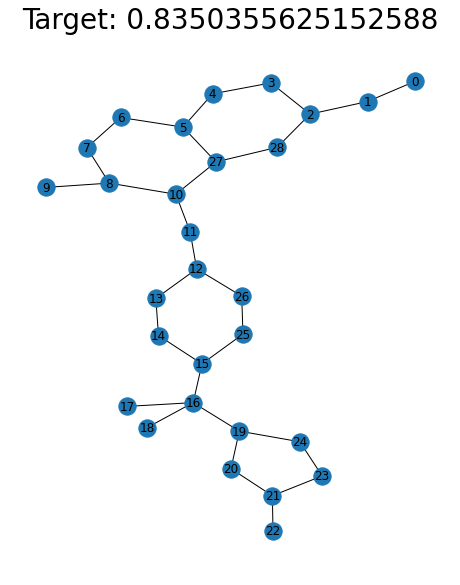

In [7]:
gallery([one_graph], labels=np.array([one_graph.y]), max_fig_size=(8,10))

# Mini-batching for graph data

Since we are now dealing with multiple graphs, we need to figure out how to store them in mini-batches, to be able to make the computation as efficient as possible. For some types of data, stacking samples in mini-batches is a trivial task. For example, images of $32\times32$ pixels are easy to batch because they have the same dimension (obtaining a tensor of dimension $batch\_{size}\times32\times32$). On the other hand, graphs come in different sizes with adjacency matrices of different shapes:

In [8]:
print(f'First graph : {train_zinc_dataset[0].x.shape} with adjacency {(train_zinc_dataset[0].num_nodes, train_zinc_dataset[0].num_nodes)}')
print(f'Second graph: {train_zinc_dataset[1].x.shape} with adjacency {(train_zinc_dataset[1].num_nodes, train_zinc_dataset[1].num_nodes)}')
print(f'Third graph : {train_zinc_dataset[2].x.shape} with adjacency {(train_zinc_dataset[2].num_nodes, train_zinc_dataset[2].num_nodes)}')

First graph : torch.Size([29, 1]) with adjacency (29, 29)
Second graph: torch.Size([26, 1]) with adjacency (26, 26)
Third graph : torch.Size([16, 1]) with adjacency (16, 16)


One solution for this is to create a single *sparse* graph as the union of all the graphs in the mini-batch as follow:

1. stack the features $x$ for all the nodes in all the graphs
2. stack the labels $y$ for all the nodes in all the graphs
3. stack all the adjacency matrices $A_i$ as diagonal blocks in the new adjacency matrix

This way, we will obtain a new graph containing $\sum_{i=1}^{B}|V_i|$ nodes, where $B$ is the batch_size and by $|V_i|$ we denote the number of nodes in graph $i$. Note that since **no** edges connect nodes from different graphs,  the  information propagation will not be affected by the way we store it.  

<center>
<img src="https://drive.google.com/uc?export=view&id=1RwI0CYA57S0OgLxgHgV6PBFNG9tnGvGR" width="500">
</center>

<center>
<img src="https://drive.google.com/uc?export=view&id=1Ux65wTJLXCfJ4TI4Up4mCHkaSja8NgrJ" width="500">
</center>


As you can see, the resulting matrix contains many zeros (sparse), thus our choice of storing the adjacency matrix as a sparse tensor can indeed bring us efficiency.

Until now, we have a way to store the graphs in a mini-batch such that they could be efficiently processed. 

However, we need to also be able to extract information from this structure, to recover the graphs that it contains. For this, we need to remember what initial graph each node belongs to.

We will do this by storing a list of indices `(self.batch)`, which map each node in the batch-graph to the initial graph it belong to. For example `batch=[0,0,0,1,1,2,2,2]` indicates that first 3 nodes belong to $G_0$, the next 2 nodes belong to $G_1$ and the last 3 nodes belong to $G_2$.



In [9]:
def create_mini_batch(graph_list: List[Graph]) -> Graph:
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)

    nodes_count = graph_list[0].num_nodes

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):
        # concat the features
        batch_x = torch.cat((batch_x, graph.x))
        # concat the labels
        batch_y = torch.cat((batch_y, graph.y))

        # concat the adjacency matrix as a block diagonal matrix

        # here we have to modify the current graph edge index by adding 
        # to the row and column the number of nodes we have already 
        # added to the batch, this way when computing the sparse block matrix,
        # we position the nodes correctly 
        batch_edge_index = torch.cat((
            batch_edge_index, 
            torch.add(graph.edge_index, nodes_count))
        , dim=1)
        nodes_count += graph.num_nodes

        # create the array of indexes mapping nodes in the batch-graph
        # to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)

        # here we append a vector of [idx+1, idx+1,...] which has dimension graph.num_nodes
        # to our existing batch_batch vector to keep track of the nodes
        batch_batch = torch.cat((
            batch_batch, 
            torch.full((graph.num_nodes,), idx + 1)
        ))

    #create the big sparse graph 
    batch_graph = Graph(batch_edge_index, batch_x, batch_y)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

Batch number_of_nodes: 12
Batch features shape: torch.Size([12, 32])
Batch labels shape: torch.Size([3])
Batch adjacency: 
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 1 0 1 1 1 0 0 0 0
0 0 0 1 0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 0 1 0 0 0


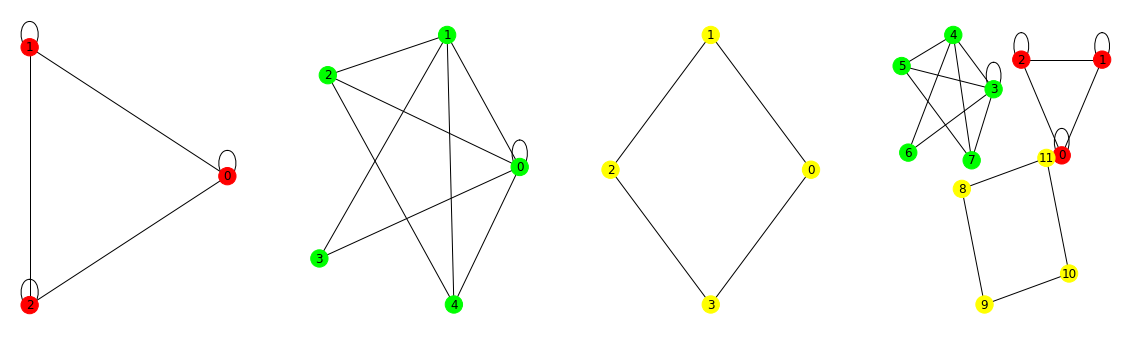

And we also have access to which graph each node belongs to tensor([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2])



In [10]:
#@title Visualize the mini-batching for a small list of batch_size=3 graphs

# 3 random custom-designed graphs for visualisations
graph1 = Graph(x=torch.rand((3,32)), 
               y=torch.rand((1)), 
               edge_index=torch.tensor([[0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]]))
graph2 = Graph(x=torch.rand((5,32)), 
               y=torch.rand((1)), 
               edge_index=torch.tensor([[0,0,0,0,0,1,1,1,2,1,2,3,4], [0,1,2,3,4,2,3,4,4,0,0,0,0]]))
graph3 = Graph(x=torch.rand((4,32)),
               y=torch.rand((1)), 
              edge_index=torch.tensor([[0,1,2,3],[1,2,3,0]]))
list_graphs = [graph1, graph2, graph3]

# create a mini-batch from these 3 graphs
batch_sample = create_mini_batch(list_graphs)

# show statistics about the new graph built from this batch of graphs
print(f"Batch number_of_nodes: {batch_sample.num_nodes}")
print(f"Batch features shape: {batch_sample.x.shape}")
print(f"Batch labels shape: {batch_sample.y.shape}")

print(f"Batch adjacency: ")
print_color_numpy(batch_sample.get_adjacency_matrix().to_dense().numpy(), list_graphs)

gallery([graph1, graph2, graph3, batch_sample], max_fig_size=(20,6), special_color=True)
print(f"And we also have access to which graph each node belongs to {batch_sample.batch}\n")


As we can see the adjacency matrix above is in a *block diagonal* structure. With this structure, effectively each graph is independent from the other - exactly what we want for batching! We would not want the representations of a graph to affect the representation of a different graph. 

# Part 1: Graph Isomorphism Network:

In [11]:
# @title [RUN] Hyperparameters GIN 

BATCH_SIZE = 128 #@param {type:"integer"}
NUM_EPOCHS =   30#@param {type:"integer"}
HIDDEN_DIM =   64#@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

#you can add more here if you need

We will design a  Graph Neural Network model, similar to the one used on Cora, with the following modifications:
* graph-level prediction instead of node-level prediction
* regression instead of classification
* to obtain *provable more powerful architecture* $^\dagger$, we will go beyond GCN Layer and implement a [**GIN Layer**](https://arxiv.org/abs/1810.00826) instead.

$^\dagger$*we will rigurously define what it means in the last section of the Practical*.

One simple instantiation of GIN Layer processes the graph according to the following message passing equation, where $\epsilon_k$ is a learnable scalar

\begin{equation}
X^{k+1}= \text{MLP}_k\big(AX^k + (1+\epsilon_k)X^k\big)
\end{equation}

### 💻 **Task 1:** Fill in the missing part that implements the core message passing equation shown above.

Tip: Make sure you use `torch.spmm` when multiplying with the adjacency matrix. 

In [12]:
import torch_scatter
#是不是可以随便改
class GINLayer(nn.Module):
    """A single GIN layer, implementing MLP(AX + (1+eps)X)"""
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int, eps: float=0.0):
        super(GINLayer, self).__init__()
        # ============ YOUR CODE HERE =============
        self.mlp = nn.Sequential(
            nn.Linear(in_feats, hidden_dim),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_feats)
        )
        self.eps = eps
        # =========================================

    def forward(self, x, adj_sparse): 
        # ============ YOUR CODE HERE =============
        #h_neigh = torch_scatter.scatter_add(x[adj_sparse[0]], adj_sparse[1], dim=0)
        h_neigh = adj_sparse @ x
        h = (1 + self.eps) * x + h_neigh
        out = self.mlp(h)
        # =========================================
        return out

Using the above GIN Layer, let's design a neural network with `num_layers` GINLayers, to solve the graph-regression task

### 💻 **Task 2:** Creates graph-representations from node-representations

In [13]:
from torch.nn.modules.linear import Linear
class SimpleGIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    is just the sum of the nodes in the graph

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, 
                 molecular=True):
        super(SimpleGIN, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # instead of nn.Linear as in SimpleMLP model, 
        # now we have (num_layers) GINLayer(s), each with different parameters
        # ============ YOUR CODE HERE =============
        self.layers = nn.ModuleList([
            GINLayer(hidden_dim, hidden_dim, 2*hidden_dim, eps=eps) 
            for _ in range(num_layers-1)
        ])
        self.last_layer = GINLayer(hidden_dim, output_dim, 2*hidden_dim, eps=eps)
        # =========================================
    
    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        # graph-level representations are obtain by (scatter) pooling info from the nodes
        # ============ YOUR CODE HERE =============
        # use a ReLU activation for each layer, except the final one
        for i in range(self.num_layers-1):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
        x = self.last_layer(x, adj_sparse)
        # graph-level representations are obtain by pooling info from the nodes
        y_hat = torch_scatter.scatter_add(x, graph.batch, dim=0)
        # =========================================

        y_hat = y_hat.squeeze(-1)
        #return also the final node embeddings x (for visualisations)
        return y_hat, x

Since now we have a proper graph network to play with, let's check if our mini-batch implementation is correct. For this, we provide an unit test checking that runing the code on individual graphs or directly on an entire batch provides the same results: 

In [14]:
#@title [RUN] Unit test for mini-batch implementation
def unit_test_mini_batch(batch):
  model = SimpleGIN(input_dim=batch[0].x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4)
  # For BN
  model.eval()
  graph_batch = create_mini_batch(batch)
  out_batch, _ = model(graph_batch)

  for i in range(BATCH_SIZE):
    batch_i = create_mini_batch([batch[i]])
    out_i, node_emb_i = model(batch_i)
    assert(np.abs(out_i.detach().numpy() - out_batch[i].detach().numpy()).mean() <1e-5 )
  print("Congrats 😊 !! Everything seems all right!")

In [15]:
#@title Run unit test for mini-batch implementation
batch = train_zinc_dataset[:BATCH_SIZE]
unit_test_mini_batch(batch)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Congrats 😊 !! Everything seems all right!


In [16]:
def train(dataset, model, optimiser, epoch, loss_fct, metric_fct, print_every):
    """ Train model for one epoch 
    """
    model.train()
    num_iter = int(len(dataset)/BATCH_SIZE)
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        optimiser.zero_grad()
        y_hat, _ = model(batch)
        loss = loss_fct(y_hat, batch.y)
        metric = metric_fct(y_hat, batch.y)
        loss.backward()
        optimiser.step() 
        if (i+1) % print_every == 0:
          print(f"Epoch {epoch} Iter {i}/{num_iter}",
                    f"Loss train {loss.data}; Metric train {metric.data}")
    return loss, metric

def evaluate(dataset, model, loss_fct, metrics_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some 
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    num_iter = int(len(dataset)/BATCH_SIZE)
    metrics_eval = 0
    loss_eval = 0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        y_hat, _ = model(batch)
        metrics = metrics_fct(y_hat, batch.y)
        loss = loss_fct(y_hat, batch.y)

        metrics_eval += metrics.data
        loss_eval += loss.data
    metrics_eval /= num_iter
    loss_eval /= num_iter
    return loss_eval, metrics_eval

In [17]:
def train_eval(model, train_dataset, val_dataset, test_dataset, 
               loss_fct, metric_fct, print_every=1):
    """ Train the model for NUM_EPOCHS epochs
    """
    #Instantiatie our optimiser
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None

    #initial evaluation (before training)
    val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
    train_loss, train_metric = evaluate(train_dataset[:BATCH_SIZE], model, 
                                        loss_fct, metric_fct)
    epoch_stats = {'train_loss': train_loss.detach(),
                   'val_loss': val_loss.detach(),
                   'train_metric': train_metric.detach(),
                   'val_metric': val_metric.detach(),'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    for epoch in range(NUM_EPOCHS):
        if isinstance(train_dataset, list):
            random.shuffle(train_dataset)
        else:
            train_dataset.shuffle()
        train_loss, train_metric = train(train_dataset, model, optimiser, epoch, 
                                        loss_fct, metric_fct, print_every)
        val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
        print(f"[Epoch {epoch+1}]",
                    f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
                    f"train metric: {train_metric:.3f} val metric: {val_metric:.3f}"
              )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss.detach(),
                       'val_loss': val_loss.detach(), 
                      'train_metric': train_metric.detach(),
                       'val_metric': val_metric.detach(), 
                      'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss, test_metric = evaluate(test_dataset, model,  loss_fct, metric_fct)
    print(f"Test metric: {test_metric:.3f}")
    return training_stats

Now it's time to train our model and enjoy the results. Make sure to check that the train loss is decreasing to at least ~0.5!

[Epoch 1] train loss: 0.715 val loss: 1.908 train metric: 0.715 val metric: 1.908
[Epoch 2] train loss: 0.580 val loss: 1.545 train metric: 0.580 val metric: 1.545
[Epoch 3] train loss: 0.463 val loss: 1.318 train metric: 0.463 val metric: 1.318
[Epoch 4] train loss: 0.463 val loss: 1.280 train metric: 0.463 val metric: 1.280
[Epoch 5] train loss: 0.408 val loss: 1.315 train metric: 0.408 val metric: 1.315
[Epoch 6] train loss: 0.379 val loss: 1.506 train metric: 0.379 val metric: 1.506
[Epoch 7] train loss: 0.361 val loss: 1.412 train metric: 0.361 val metric: 1.412
[Epoch 8] train loss: 0.365 val loss: 1.542 train metric: 0.365 val metric: 1.542
[Epoch 9] train loss: 0.339 val loss: 1.457 train metric: 0.339 val metric: 1.457
[Epoch 10] train loss: 0.327 val loss: 1.412 train metric: 0.327 val metric: 1.412
[Epoch 11] train loss: 0.345 val loss: 1.307 train metric: 0.345 val metric: 1.307
[Epoch 12] train loss: 0.353 val loss: 1.289 train metric: 0.353 val metric: 1.289
[Epoch 13] tr

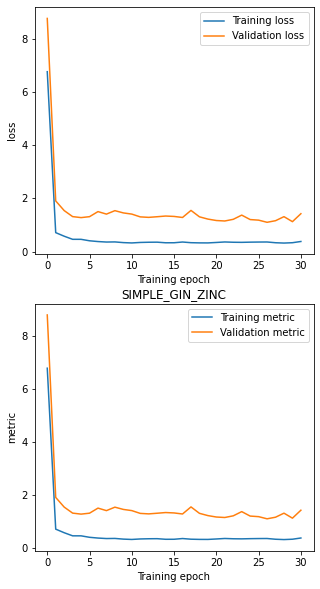

In [18]:
#Train GIN model:
model_simple_gin = SimpleGIN(input_dim=train_zinc_dataset[0].x.size()[-1],
                             output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4,
                             eps=0.1)
train_stats_simple_gin_zinc = train_eval(model_simple_gin, train_zinc_dataset, val_zinc_dataset, 
                                         test_zinc_dataset, loss_fct=F.mse_loss, 
                                         metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_simple_gin_zinc, name='SIMPLE_GIN_ZINC', figsize=(5, 10))

The full GIN architecture, as introduced in the original [paper](https://arxiv.org/pdf/1810.00826.pdf), does not use only the final output for predictions. Instead, it creates a graph representation from the representation of all the intermediate layers:

\begin{equation}
h_G = CONCAT\big(\oplus_{v \in G}\{h_v^{(k)}\}| k=0,1..(K-1) \big)
\end{equation}

where $\oplus_{v \in G}\{h_v^{(k)}\}$ represents the graph-level representations at layer $k$, obtained by summing the representations from all the nodes $v \in G$

\\

### 💻 **Task 3:** Implement the entire architecture as described above.

In [19]:
class GIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, \
                 molecular=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers #please select num_layers >=1
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # ============ YOUR CODE HERE =============
        # should be the same as before (an nn.ModuleList of GINLayers)
        self.layers = nn.ModuleList([
            GINLayer(hidden_dim, hidden_dim, 2*hidden_dim, eps=eps) 
            for _ in range(num_layers)
        ])

        self.out = nn.Linear((num_layers)*hidden_dim, output_dim)
        # layer to compute prediction from the concatenated intermediate representations
        # self.pred_layers = ...
        # =========================================

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        # ============ YOUR CODE HERE ============= 
        # perform the forward pass with the new readout function 
        # use a ReLU activation for each layer, except the final one
        hist = []
        for i in range(self.num_layers):
            x = self.layers[i](x, adj_sparse)
            if i!=self.num_layers-1:
                x = F.relu(x)
            hist.append(x)

        h_jk = torch.cat(hist, dim=1)
        h_g = torch_scatter.scatter_add(h_jk, graph.batch, dim=0)
        y_hat = self.out(h_g)


        # =========================================
        # return also the final node embeddings (for visualisations)
        y_hat = y_hat.squeeze(-1)
        return y_hat, x


[Epoch 1] train loss: 0.932 val loss: 1.568 train metric: 0.932 val metric: 1.568
[Epoch 2] train loss: 0.989 val loss: 1.609 train metric: 0.989 val metric: 1.609
[Epoch 3] train loss: 0.860 val loss: 1.595 train metric: 0.860 val metric: 1.595
[Epoch 4] train loss: 0.874 val loss: 1.531 train metric: 0.874 val metric: 1.531
[Epoch 5] train loss: 0.911 val loss: 1.411 train metric: 0.911 val metric: 1.411
[Epoch 6] train loss: 0.851 val loss: 1.457 train metric: 0.851 val metric: 1.457
[Epoch 7] train loss: 0.819 val loss: 1.352 train metric: 0.819 val metric: 1.352
[Epoch 8] train loss: 0.786 val loss: 1.429 train metric: 0.786 val metric: 1.429
[Epoch 9] train loss: 0.707 val loss: 1.139 train metric: 0.707 val metric: 1.139
[Epoch 10] train loss: 0.689 val loss: 1.201 train metric: 0.689 val metric: 1.201
[Epoch 11] train loss: 0.658 val loss: 1.230 train metric: 0.658 val metric: 1.230
[Epoch 12] train loss: 0.661 val loss: 1.120 train metric: 0.661 val metric: 1.120
[Epoch 13] tr

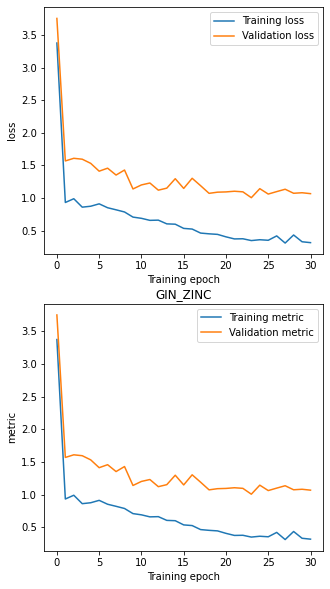

In [20]:
#Train GIN model:
model_gin = GIN(input_dim=train_zinc_dataset[0].x.size()[-1], output_dim=1,
                hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)
train_stats_gin_zinc = train_eval(model_gin, train_zinc_dataset, val_zinc_dataset, 
                                  test_zinc_dataset, loss_fct=F.mse_loss, 
                                  metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_gin_zinc, name='GIN_ZINC', figsize=(5, 10))

# Part 2: Expressive Power of Graph Neural Networks



You should be already confident that Graph Neural Networks represents powerful tools to process graph-data. However, there are some theoretically proven limitations that you should be aware of. From now on, your goal in this practical will be to **understand and overcome these limitations**.

In the following, we will look at 2 hard to distinguish  graphs and try to understand what are the problems that GNNs are not able to solve and why this happens.

In [21]:
#@title [RUN] Hard to distinguish graphs
def gen_hard_graphs_WL():
  """maybe change with something smarter.
  are these graphs somewhere?
  """
  
  x1 = torch.ones((10,1))
  edge_index1 = torch.tensor([[1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
                 [2, 5, 1, 3, 2, 4, 6, 3, 5, 1, 4, 3, 7, 10, 6, 8, 7, 9, 8, 10, 6, 9]])-1
  y1 = torch.tensor([1])

  x2 = torch.ones((10,1))
  edge_index2 = torch.tensor([[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
                 [2, 6, 1, 3, 7, 2, 4, 10, 3, 5, 4, 6, 1, 5, 2, 8, 7, 9, 8, 10, 3, 9]])-1
  y2 =  torch.tensor([2])  

  graph1 = Graph(x=x1, edge_index=edge_index1, y=y1)
  graph2 = Graph(x=x2, edge_index=edge_index2, y=y2)
  return [graph1, graph2]

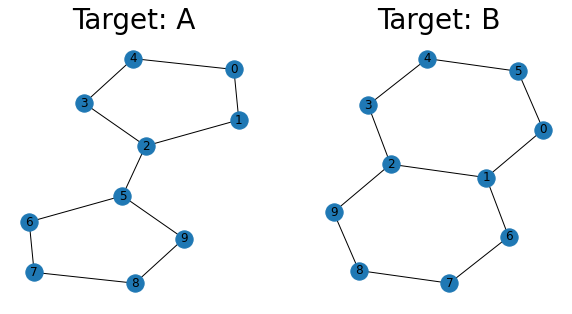

In [22]:
hard_graphs = gen_hard_graphs_WL()
gallery(hard_graphs, labels=["A","B"], max_fig_size=(10,5))

Let's try to encode these graphs using our GIN Neural Network.

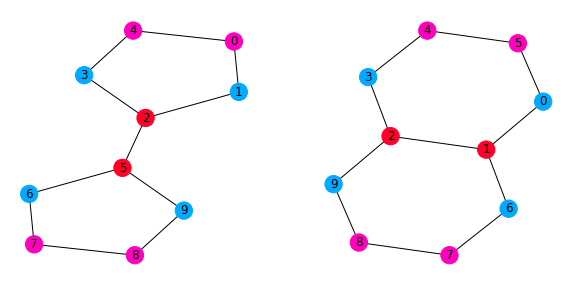

In [23]:
hard_batch = create_mini_batch(hard_graphs)
out, node_emb = model_simple_gin(hard_batch)

#split node_emb from batch into separate graphs
node_emb = node_emb.detach().numpy()
node_emb_split=[node_emb[:hard_graphs[0].num_nodes], node_emb[hard_graphs[0].num_nodes:]]

#encode node representation into an int in [0,1] denoting the color
node_emb_split = hash_node_embedings(node_emb_split)


gallery(hard_graphs, node_emb=node_emb_split, max_fig_size=(10,5))


In the visualisation from above, the colors indicate the nodes embedings, as predicted by the model. Remember from the course that, to obtain a graph-level representation, we pool the nodes embedings using a *permutation invariant* function. This means that the multisets of colors determine the graph embeding. More exactly, if two graphs are encoded using the same multisets of colors, the final graph-representation will be the same.
This means that from the graph-level perspective the 2 graphs shown above are the same. However, for a human, it is obvious that this is not true.

**Why this is happening ❓**

Let's look at how the node embedings are computed by a 5-layer GNN.



<!-- <center> -->
<img src="https://drive.google.com/uc?export=view&id=1Jt6zJVApmgS9VFbcKpzxOoBtrxos55iu" width="1000">
<!-- </center> -->

If we are looking into how the computational network looks like for the two graphs in 5 steps, we observe that they essentially looks very similar. The **important** difference that we are able to spot, while the GNNs are not, is that, after 5 layers of propagation, in one graph (left) we reach the same note from where we've started, while in the other graph (right) we reach a different one. Since from the structure persective the 2 nodes are the same, the GNN will encode them the same without realising the difference between them. 

In the next section we will try to find how can we alleviate this and what could be the practical implications this problem raise.

# Improving the expressive power

As we have seen in the example above, GIN (and MPNNs in general) cannot distinguih any pair of non-isomorphic graphs. Based on this, we can devise a hierarchy of GNN models based on what pairs of graphs they can or cannot distinguish. 

**Definition.** *We say that a GNN model B is strictly more powerful than another model A if B can distinguish all the pairs of attributed graphs that A can distinguish and there exists a pair of attributed graphs that B can distiguish but A cannot.*

In this section, we are going to build a GNN model that is more powerful than GIN and design a synthetic task on which this can be evaluated emprically. Then, you will also be asked to prove mathematically that your model is indeed more powerful.

### 💻**Task 4:** Construct a graph classification or regression task where a model with superior expressive power should do better than GIN.

Hint: Try to find more examples of pairs of graphs that GIN cannot distiguish and generalise them into a dataset.

We recommend building upon the latter functions:
* `generate_graph_1` - Generates the first base graph
* `generate_graph_2` - Generates the second base graph such that it is $1$-WL indistinguishable from graph 1 
* `manipulate_base_graphs` - Manipulates the two base graphs to construct a dataset of graphs such that every graph in class $1$ has a pair in class $2$ such that the two are $1$-WL indistinguishable 

The idea is that `generate_graph_1` will generate a family of graphs $\mathsf{G}_1$ and `generate_graph_2` will generate the other family $\mathsf{G}_2$. Then for any $g_1 \in \mathsf{G}_1$ there exists a graph $g_2 \in \mathsf{G}_2$ such that $g_1$ and $g_2$ are indistinguishable under the $1$-WL test. 

Hint: You can start by looking at the example graphs above. Try to then think of a way of adding nodes and edges such that they still preserve the property of being indistinguishable from each other under the $1$-WL test. *Make sure that the graphs remain connected.*

In [24]:
# keep NUM_NODES to an even number
NUM_NODES = 8
HALF_NODES = int(NUM_NODES / 2)
import torch_geometric.utils as tgutils
def generate_graph_1():
  x = torch.ones((NUM_NODES, 1))
  y = torch.tensor([0])
  # ============ YOUR CODE HERE =============
  # important node 1,4
  edge_index = tgutils.to_undirected(torch.tensor([
    [2,1],
    [1,0],
    [0,3],
    [3,2],
    [5,4],
    [4,6],
    [6,7],
    [7,5],
    [1,4],
  ]).T)
  # =========================================
  return x, y, edge_index

def generate_graph_2():
  x = torch.ones((NUM_NODES, 1))
  y = torch.tensor([1])
  # ============ YOUR CODE HERE =============
  edge_index = tgutils.to_undirected(torch.tensor([
    [1,0],
    [0,4],
    [4,3],
    [3,2],
    [1,2],
    [1,2],
    [0,5],
    [0,5],
    [6,5],
    [6,5],
    [1,7],
    [1,7],
    [7,6],
  ]).T)

  # =========================================
  return x, y, edge_index

def manipulate_base_graphs(edge_index1, y1, edge_index2, y2):
  new_graphs = []
  # ============ YOUR CODE HERE =============
  NUM_GRAPH_TO_GENERATE = 499
  NUM_EXTRA_NODES = 8
  for _ in range(NUM_GRAPH_TO_GENERATE):
    g_nx = None
    while g_nx is None or not nx.is_connected(g_nx):
      g_nx = nx.gnp_random_graph(NUM_EXTRA_NODES, 0.2)
    edge_index_nx = tgutils.to_undirected(
      torch.tensor(list(g_nx.edges())).T
    ) + NUM_NODES
    for base_edge_index, p1, p2, y in [(edge_index1, 1, 4, 0), (edge_index2, 0, 1, 1)]:

      x = torch.ones((NUM_NODES + NUM_EXTRA_NODES, 1), dtype=torch.float)
      edge_index = torch.cat([
        base_edge_index,
        edge_index_nx,
        torch.tensor([[p1,p2,NUM_NODES,NUM_NODES], [NUM_NODES,NUM_NODES,p1,p2]])
      ], dim=1)
      new_graphs.append(Graph(x=x, edge_index=edge_index, y=torch.tensor([y], dtype=torch.float)))

  # =========================================
  return new_graphs

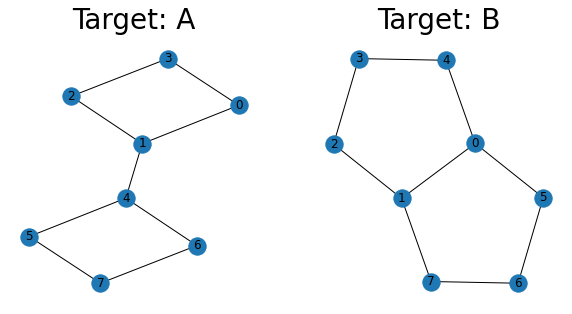

In [25]:
x1, y1, edge_index1 = generate_graph_1()
x2, y2, edge_index2 = generate_graph_2()
hard_graphs = [
    Graph(x=x1, edge_index=edge_index1, y=y1),
    Graph(x=x2, edge_index=edge_index2, y=y2)
]
gallery(hard_graphs, labels=["A","B"], max_fig_size=(10,5))

In [26]:
def generate_dataset():
  x1, y1, edge_index1 = generate_graph_1()
  print(x1, y1, edge_index1)
  x2, y2, edge_index2 = generate_graph_2()

  graphs = []

  graph1 = Graph(x=x1, edge_index=edge_index1, y=y1)
  graphs.append(graph1)

  graph2 = Graph(x=x2, edge_index=edge_index2, y=y2)
  graphs.append(graph2)

  return graphs + manipulate_base_graphs(edge_index1, y1, edge_index2, y2)

Visualize your dataset:

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]) tensor([0]) tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7],
        [1, 3, 0, 2, 4, 1, 3, 0, 2, 1, 5, 6, 4, 7, 4, 7, 5, 6]])


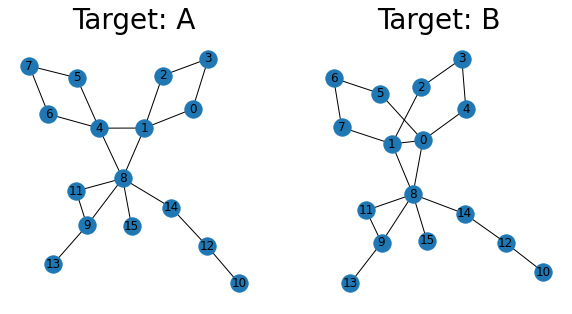

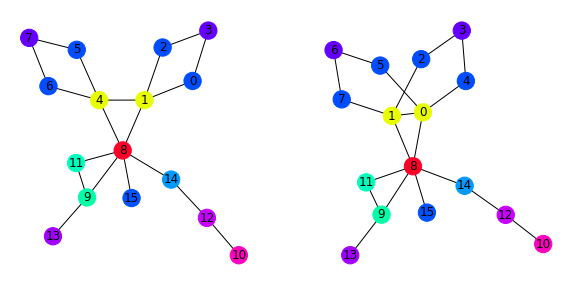

In [27]:
generated_dataset = generate_dataset()
visualized_dataset = generated_dataset[-2:]
gallery(visualized_dataset, labels=["A","B"], max_fig_size=(10,5))

hard_batch = create_mini_batch(visualized_dataset)
out, node_emb = model_simple_gin(hard_batch)

#split node_emb from batch into separate graphs
node_emb = node_emb.detach().numpy()
node_emb_split=[node_emb[:visualized_dataset[0].num_nodes], node_emb[visualized_dataset[0].num_nodes:]]

#encode node representation into an int in [0,1] denoting the color
node_emb_split = hash_node_embedings(node_emb_split)
gallery(visualized_dataset, node_emb=node_emb_split, max_fig_size=(10,5))

Split your dataset:

In [28]:
train_percentage, val_percentage = 0.4, 0.2
train_split = int(len(generated_dataset) * train_percentage)
val_split = int(len(generated_dataset) * val_percentage)

# training set 40% 
train_set = generated_dataset[:train_split] 

# validation set is 20%
val_set = generated_dataset[train_split:train_split + val_split] 

# test set is 40%
test_set = generated_dataset[train_split + val_split:]

print(f"Train graphs: {len(train_set)}")
print(f"Validation graphs: {len(val_set)}")
print(f"Test graphs: {len(test_set)}")
print(f"Total graphs: {len(generated_dataset)}")

Train graphs: 400
Validation graphs: 200
Test graphs: 400
Total graphs: 1000


### The GIN on the task you have created

If you have done this correctly, you should expect an accuracy of $0.5$ which corresponds to random guessing.

In [29]:
def train_eval_test(model, train_data, val_data, test_data, name):
  train_stats = train_eval(model, train_data, val_data, 
                           test_data, loss_fct=F.mse_loss, 
                           metric_fct=F.mse_loss, print_every=20000)
  plot_stats(train_stats, name=name, figsize=(5, 10))

  correct = 0
  out, _ = model(create_mini_batch(test_data))
  for pred, label in zip(out, test_data):
    if round(pred.item()) == label.y.item():
      correct +=1
  acc = correct/len(out)
  print(f"Accuracy: {acc}")

[Epoch 1] train loss: 0.698 val loss: 0.793 train metric: 0.698 val metric: 0.793
[Epoch 2] train loss: 0.886 val loss: 0.422 train metric: 0.886 val metric: 0.422
[Epoch 3] train loss: 0.115 val loss: 0.677 train metric: 0.115 val metric: 0.677
[Epoch 4] train loss: 0.522 val loss: 1.635 train metric: 0.522 val metric: 1.635
[Epoch 5] train loss: 0.254 val loss: 0.475 train metric: 0.254 val metric: 0.475
[Epoch 6] train loss: 0.331 val loss: 0.654 train metric: 0.331 val metric: 0.654
[Epoch 7] train loss: 0.343 val loss: 1.440 train metric: 0.343 val metric: 1.440
[Epoch 8] train loss: 0.221 val loss: 1.019 train metric: 0.221 val metric: 1.019
[Epoch 9] train loss: 0.404 val loss: 0.464 train metric: 0.404 val metric: 0.464
[Epoch 10] train loss: 0.242 val loss: 0.954 train metric: 0.242 val metric: 0.954
[Epoch 11] train loss: 0.147 val loss: 0.492 train metric: 0.147 val metric: 0.492
[Epoch 12] train loss: 0.335 val loss: 0.341 train metric: 0.335 val metric: 0.341
[Epoch 13] tr

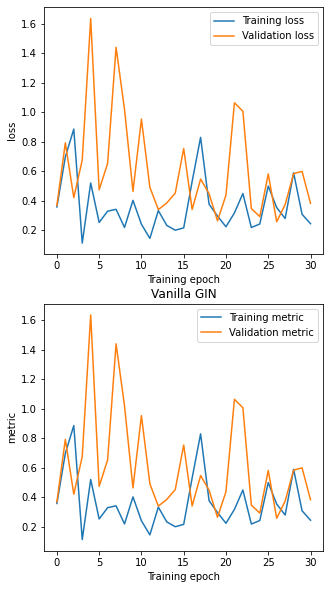

In [30]:
BATCH_SIZE = 5
model = SimpleGIN(input_dim=train_set[0].x.size()[-1],
                  output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1,
                  molecular=False)
train_eval_test(model=model, train_data=train_set, val_data=val_set, test_data=test_set, name='Vanilla GIN')

### 💻**Task 5:** Think of a feature augmentation procedure that can increase the expressive power of GIN. Is GIN + Feature Augmentation better than GIN on your synthetic task? Explain your results.

How can you augment the initial graph features with additional information about the graph that could lead to higher discriminativity when applying a GIN model on top? Note that adding a boolean flag for the two different types of graphs is not a valid solution. In particular, think of a feature augmentation that will help you distinguish the synthetic graphs generated in the previous task.

Hint: You can try to look at quantities related to the adjacency matrix

In [31]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data.x)

tensor([[-1.],
        [ 0.],
        [ 1.]])


In [32]:
from networkx.algorithms.shortest_paths import floyd_warshall_numpy
def augment(graph):
  # ============ YOUR CODE HERE =============
  # Implement GIN with Feature Augmentation
  g_nx = nx.Graph(graph.edge_index.T.tolist())
  dist = floyd_warshall_numpy(g_nx)
  #print(dist)
  d2 = (dist==2).sum(axis=1)
  augmentation = torch.from_numpy(d2).float().reshape(-1,1)
  # =========================================
  #print(graph.edge_index)
  augmented_features = augmentation#torch.cat((graph.x, augmentation), dim=1)
  #print(graph.x)
  #print(augmented_features)
  #data = Graph(x=augmented_features, edge_index=graph.edge_index, y=graph.y.float())
  #print(data.x)
  return Graph(x=augmented_features, edge_index=graph.edge_index, y=graph.y.float())

augmented_train_set = [augment(graph) for graph in train_set]
augmented_val_set = [augment(graph) for graph in val_set]
augmented_test_set = [augment(graph) for graph in test_set]

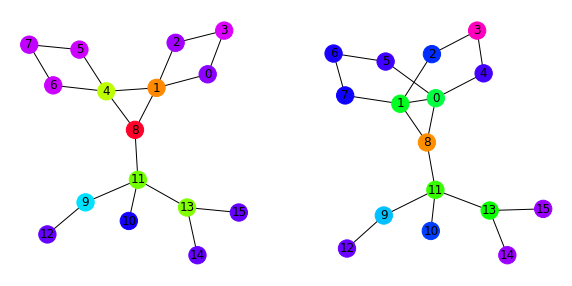

In [33]:
# Evaluates your model on your new dataset against GIN with Feature Augmentation
evaluation_dataset = augmented_val_set[-2:]
batch_hard_train_augmented = create_mini_batch(evaluation_dataset)
model = SimpleGIN(input_dim=batch_hard_train_augmented.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1, molecular=False)

hard_batch = create_mini_batch(evaluation_dataset)
out, node_emb = model(hard_batch)

#split node_emb from batch into separate graphs
node_emb = node_emb.detach().numpy()
node_emb_split=[node_emb[:evaluation_dataset[0].num_nodes], node_emb[evaluation_dataset[0].num_nodes:]]

#encode node representation into an int in [0,1] denoting the color
node_emb_split = hash_node_embedings(node_emb_split)
gallery(evaluation_dataset, node_emb=node_emb_split, max_fig_size=(10,5))

#### Feature Augmentation GIN

Remember that without feature augmentation we obtained an accuracy of $0.5$, corresponding to random guessing. The hope is that with the feature augmentation we can distinguish all of the graphs from each other and obtain an accuracy of $1.0$. 

[Epoch 1] train loss: 0.075 val loss: 2.134 train metric: 0.075 val metric: 2.134
[Epoch 2] train loss: 0.160 val loss: 0.104 train metric: 0.160 val metric: 0.104
[Epoch 3] train loss: 0.179 val loss: 0.310 train metric: 0.179 val metric: 0.310
[Epoch 4] train loss: 0.065 val loss: 0.077 train metric: 0.065 val metric: 0.077
[Epoch 5] train loss: 0.062 val loss: 0.076 train metric: 0.062 val metric: 0.076
[Epoch 6] train loss: 0.135 val loss: 0.134 train metric: 0.135 val metric: 0.134
[Epoch 7] train loss: 0.039 val loss: 0.040 train metric: 0.039 val metric: 0.040
[Epoch 8] train loss: 0.013 val loss: 0.091 train metric: 0.013 val metric: 0.091
[Epoch 9] train loss: 0.115 val loss: 0.183 train metric: 0.115 val metric: 0.183
[Epoch 10] train loss: 0.031 val loss: 0.992 train metric: 0.031 val metric: 0.992
[Epoch 11] train loss: 0.049 val loss: 0.796 train metric: 0.049 val metric: 0.796
[Epoch 12] train loss: 0.065 val loss: 0.201 train metric: 0.065 val metric: 0.201
[Epoch 13] tr

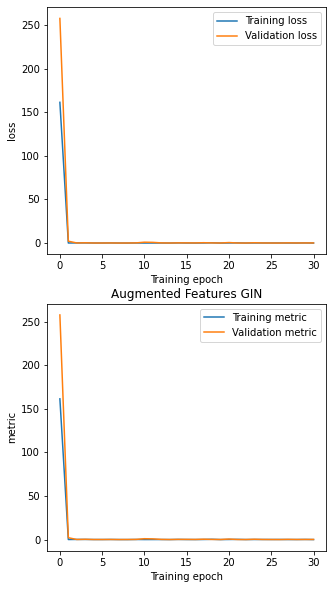

In [34]:
model = SimpleGIN(input_dim=augmented_train_set[0].x.size()[-1],
                  output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1,
                  molecular=False)
train_eval_test(model=model, train_data=augmented_train_set, val_data=augmented_val_set,
                test_data=augmented_test_set, name='Augmented Features GIN')

### 💻**Bonus Task** Prove mathematically that GIN + Feature Augmentation is indeed strictly more powerful than vanilla GIN

Following our definition of more powerful, we will adopt a two steps approach. Firstly, prove that your model is at least as powerful as GIN (i.e. it can also distiguish all pairs that GIN can distinguish) and, secondly, that your model can also distinguish additional pairs compared to GIN. 

Let us write the local aggregation performed by GIN more abstractly as $x_v^{k+1} = f_{\text{GIN}}(x_v^k, \{\{ x_u^k \mid u \in \mathcal{N}(v)\}\})$, where $\{\{ ... \}\}$ denotes a multiset and $x_v^k$ the feature of node $v$ at layer $k$. Notice that GIN is maximally expressive when $f_{\text{GIN}}$ is injective because it allows it to map different neighbourhoods to different embeddings, which leads to higher discriminative power. We will use as a fact (i.e. no proof) that there exist a set of parameters that make $f_{\text{GIN}}$ injective. 

Thus, for the first part of the proof, prove the following steps:

**Step 1:** Denote by $x_v^k$ the features of node $v$ at layer $k$ of a GIN model with injective layers. Similarly, denote by $y_v^k$ the features of a second GIN model with injective layers and augmented features at $k=0$. Prove by induction that for any two nodes $v, u$ from two arbitrary graphs, if $y_v^k = y_u^k$, then $x_v^k = x_u^k$. 

**Step 2:** Prove that for any two graphs $\mathcal{G_1}, \mathcal{G_2}$, if $\{\{x_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} \neq \{\{x_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$, then $\{\{y_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} \neq \{\{y_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$. 

***Proof.*** Add you proof here

**Step 1**: Proof by induction

- Base case $k=0$
  - Let the augmented feature of node $v$ be $a_v$.
  - $y^0_v=x^0_v||a_v$
  - Now because $y_v^0 = y_u^0$, then it must be $x_v^0 = x_u^0$ and $a_v = a_u$
- Inductive case $k \rightarrow k+1$
  - $y_u^{k+1} = f_{\text{GIN}}(y_u^k, \{\{ y_i^k \mid i \in \mathcal{N}(u)\}\}) = f_{\text{GIN}}(y_v^k, \{\{ y_i^k \mid i \in \mathcal{N}(v)\}\}) = y_v^{k+1}$ 
  - Because $f_{\text{GIN}}$ is injective, it must be that
    - $y_u^k=y_v^k$
    - $\{\{ y_i^k \mid i \in \mathcal{N}(v)\}\} = \{\{ y_i^k \mid i \in \mathcal{N}(v)\}\}$
      - By IH $\{\{ x_i^k \mid i \in \mathcal{N}(v)\}\} = \{\{ x_i^k \mid i \in \mathcal{N}(v)\}\}$
  - Substitute these equalities to $x_u^{k+1}=f_{\text{GIN}}(...)$, we find $x_u^{k+1}=x_v^{k+1}$

**Step 2**: Proof by contradiction, there exist two graphs $G_1$ and $G_2$, $\{\{x_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} \neq \{\{x_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$ but $\{\{y_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} = \{\{y_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$

- WLOG there exists a injective mapping $m: V_{G_1} \rightarrow V_{G_2}$ s.t. $y_{u}^k=y_{m(u)}^k$.
- By Step 1, $x_{u}^k=x_{m(u)}^k$
- So $\{\{x_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} = \{\{x_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$, contradicts